### Instalación de librerías necesarias

In [1]:
%pip install pandas matplotlib seaborn numpy opencv-python scikit-learn tensorflow ultralytics kaggle

Note: you may need to restart the kernel to use updated packages.


# Preparación de los datos
---
---

### Imports

In [ ]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from ultralytics import YOLO

# Scripts personalizados en directorio 'utils'
from utils import (
    split_data, ML_models, 
    balance_dataset, 
    test_YOLO
)

os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"


2025-10-03 11:13:52.396415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 11:13:52.845338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 11:13:54.444295: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Descarga de dataset (Kaggle)

In [3]:
os.system('kaggle datasets download -d vbookshelf/computed-tomography-ct-images -p ./data --unzip')
rmv_file = 'data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/split_data.py'
if os.path.isfile(rmv_file):
    os.remove(rmv_file)

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/computed-tomography-ct-images
License(s): other



100%|█████████████████████████████████████| 90.2M/90.2M [00:00<00:00, 2.25GB/s]


### Diagnóstico de hemorragias y pacientes

In [4]:
hemorrhage_diagnosis_df = pd.DataFrame(pd.read_csv('data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/hemorrhage_diagnosis.csv'))
patient_demographics_df = pd.DataFrame(pd.read_csv('data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/patient_demographics.csv'))

display(hemorrhage_diagnosis_df.head())
display(patient_demographics_df.head())

print(hemorrhage_diagnosis_df.columns, '\n')
print(patient_demographics_df.columns)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


,Patient Number,Age\n(years),Gender,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No),Condition on file,Note
0,49,35.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN
1,50,0.583333,Female,NaN,1.0,NaN,NaN,NaN,1.0,Subdural HGE,NaN
2,51,5.000000,Male,NaN,1.0,NaN,NaN,1.0,1.0,Extadural HGE,NaN
3,52,8.000000,Male,NaN,NaN,NaN,1.0,NaN,1.0,Extadural HGE,NaN
4,53,44.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN


Index(['PatientNumber', 'SliceNumber', 'Intraventricular', 'Intraparenchymal',
       'Subarachnoid', 'Epidural', 'Subdural', 'No_Hemorrhage',
       'Fracture_Yes_No'],
      dtype='object') 

Index(['Patient Number', 'Age\n(years)', 'Gender', 'Intraventricular',
       'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural',
       'Fracture (Yes/No)', 'Condition on file', 'Note'],
      dtype='object')


### Renombramiento de variables

In [5]:
hemorrhage_diagnosis_df.rename(columns={"PatientNumber": "Patient Number"}, inplace=True)
hemorrhage_diagnosis_df.rename(columns={"SliceNumber": "Slice Number"}, inplace=True)
hemorrhage_diagnosis_df.rename(columns={"Fracture_Yes_No": "Fracture (Yes/No)"}, inplace=True)
patient_demographics_df.rename(columns={"Age\n(years)": "Age (years)"}, inplace=True)

hemorrhage_diagnosis_df.columns = hemorrhage_diagnosis_df.columns.str.replace(' ', '_')
patient_demographics_df.columns = patient_demographics_df.columns.str.replace(' ', '_')

print(hemorrhage_diagnosis_df.columns, '\n')
print(patient_demographics_df.columns)


Index(['Patient_Number', 'Slice_Number', 'Intraventricular',
       'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural',
       'No_Hemorrhage', 'Fracture_(Yes/No)'],
      dtype='object') 

Index(['Patient_Number', 'Age_(years)', 'Gender', 'Intraventricular',
       'Intraparenchymal', 'Subarachnoid', 'Epidural', 'Subdural',
       'Fracture_(Yes/No)', 'Condition_on_file', 'Note'],
      dtype='object')


### Valores nulos y dtypes

In [6]:
display(hemorrhage_diagnosis_df.isna().sum())
display(hemorrhage_diagnosis_df.dtypes)

Patient_Number       0
Slice_Number         0
Intraventricular     0
Intraparenchymal     0
Subarachnoid         0
Epidural             0
Subdural             0
No_Hemorrhage        0
Fracture_(Yes/No)    0
dtype: int64

Patient_Number       int64
Slice_Number         int64
Intraventricular     int64
Intraparenchymal     int64
Subarachnoid         int64
Epidural             int64
Subdural             int64
No_Hemorrhage        int64
Fracture_(Yes/No)    int64
dtype: object

In [7]:
display(patient_demographics_df.isna().sum())
display(patient_demographics_df.dtypes)

Patient_Number        0
Age_(years)           0
Gender                0
Intraventricular     77
Intraparenchymal     66
Subarachnoid         75
Epidural             61
Subdural             78
Fracture_(Yes/No)    60
Condition_on_file     0
Note                 81
dtype: int64

Patient_Number         int64
Age_(years)          float64
Gender                object
Intraventricular     float64
Intraparenchymal     float64
Subarachnoid         float64
Epidural             float64
Subdural             float64
Fracture_(Yes/No)    float64
Condition_on_file     object
Note                  object
dtype: object

### Limpieza

In [8]:
cols_to_convert = [
    'Intraventricular', 
    'Intraparenchymal', 
    'Subarachnoid', 
    'Epidural', 
    'Subdural', 
    'Fracture_(Yes/No)'
]

patient_demographics_df[cols_to_convert] = (
    patient_demographics_df[cols_to_convert].fillna(0).astype(int)
)

patient_demographics_df[['Gender', 'Condition_on_file']] = (
    patient_demographics_df[['Gender', 'Condition_on_file']].astype('category')
)

patient_demographics_df = patient_demographics_df.drop(['Note'], axis=1)

display(patient_demographics_df.isna().sum())
display(patient_demographics_df.dtypes)
   

Patient_Number       0
Age_(years)          0
Gender               0
Intraventricular     0
Intraparenchymal     0
Subarachnoid         0
Epidural             0
Subdural             0
Fracture_(Yes/No)    0
Condition_on_file    0
dtype: int64

Patient_Number          int64
Age_(years)           float64
Gender               category
Intraventricular        int64
Intraparenchymal        int64
Subarachnoid            int64
Epidural                int64
Subdural                int64
Fracture_(Yes/No)       int64
Condition_on_file    category
dtype: object

### Datos duplicados

In [9]:
hemorrhage_diagnosis_df.duplicated().sum()

np.int64(0)

In [10]:
patient_demographics_df.duplicated().sum()

np.int64(0)

### Añadir ruta de tomografías y máscaras (si existe) al dataframe

In [11]:
base_dir = "data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT"

# Brain
hemorrhage_diagnosis_df["brain_path"] = hemorrhage_diagnosis_df.apply(
    lambda row: os.path.join(
        base_dir,
        str(row["Patient_Number"]).zfill(3),
        "brain",
        f"{row['Slice_Number']}.jpg"
    ),
    axis=1
)

# Masks
hemorrhage_diagnosis_df["has_brain_mask"] = hemorrhage_diagnosis_df.apply(
    lambda row: os.path.join(
        base_dir,
        str(row["Patient_Number"]).zfill(3),
        "brain",
        f"{row['Slice_Number']}_HGE_Seg.jpg"
    ) if os.path.exists(os.path.join(
        base_dir,
        str(row["Patient_Number"]).zfill(3),
        "brain",
        f"{row['Slice_Number']}_HGE_Seg.jpg"
    )) else False,
    axis=1
)

# Bone
hemorrhage_diagnosis_df["bone_path"] = hemorrhage_diagnosis_df.apply(
    lambda row: os.path.join(
        base_dir,
        str(row["Patient_Number"]).zfill(3),
        "bone",
        f"{row['Slice_Number']}.jpg"
    ),
    axis=1
)


In [12]:
hemorrhage_diagnosis_df.head()

,Patient_Number,Slice_Number,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_(Yes/No),brain_path,has_brain_mask,bone_path
0,49,1,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
1,49,2,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
2,49,3,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
3,49,4,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
4,49,5,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...


### Ejemplo de visualización de tomografía

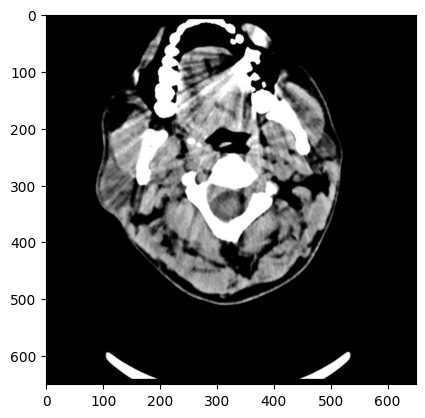

In [13]:
img = image.load_img(hemorrhage_diagnosis_df['brain_path'].iloc[0])
img_array = image.img_to_array(img) / 255.0 

plt.imshow(img_array.astype('float'))
plt.show()

# Análisis exploratorio
---
---

### hemorrhage_diagnosis_df EDA

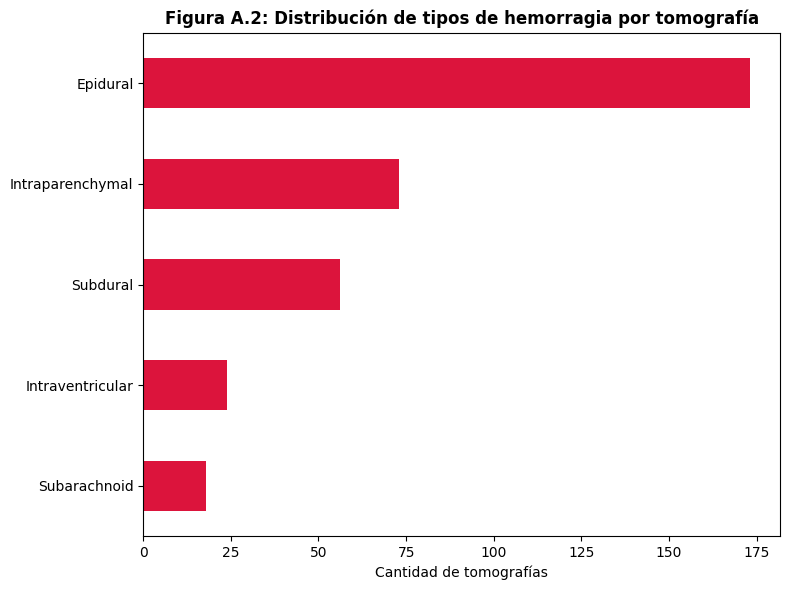

In [14]:
hem_types = ["Intraventricular", "Intraparenchymal", "Subarachnoid", "Epidural", "Subdural"]

plt.figure(figsize=(8,6))
hemorrhage_diagnosis_df[hem_types].sum().sort_values().plot(kind="barh", color="crimson")
plt.title("Figura A.2: Distribución de tipos de hemorragia por tomografía", fontweight="bold")
plt.xlabel("Cantidad de tomografías")
plt.tight_layout()
plt.show()


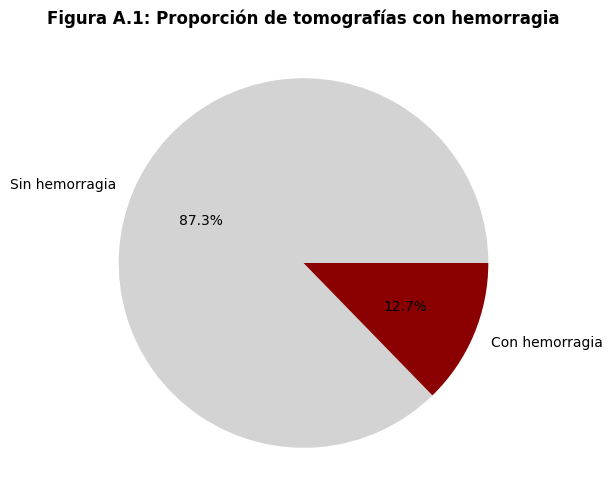

In [15]:
hem_types = ["Intraventricular", "Intraparenchymal", "Subarachnoid", "Epidural", "Subdural"]
counts = hemorrhage_diagnosis_df[hem_types].sum(axis=1) > 0

plt.figure(figsize=(8,6))

counts.value_counts().plot.pie(
    autopct="%1.1f%%",
    labels=["Sin hemorragia", "Con hemorragia"],
    colors=["lightgray", "darkred"]
)

plt.title("Figura A.1: Proporción de tomografías con hemorragia", fontweight="bold")
plt.ylabel("")
plt.show()



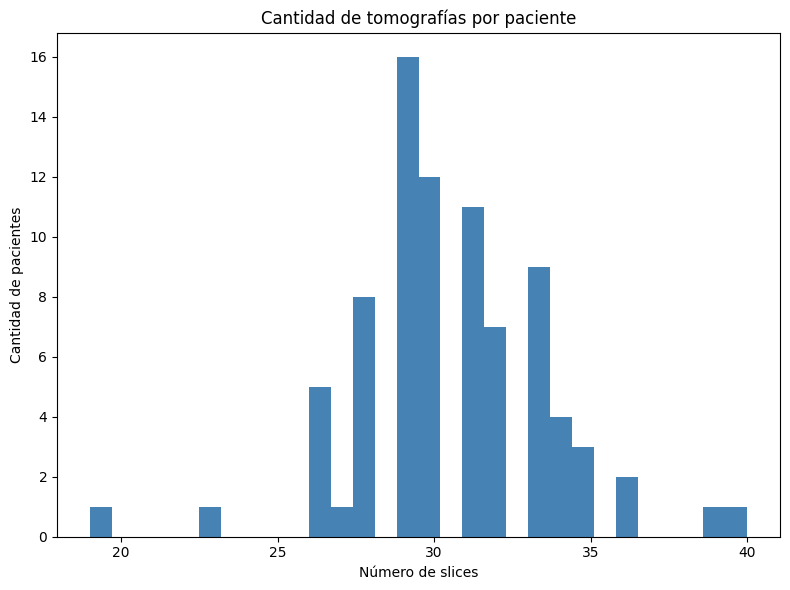

In [16]:
plt.figure(figsize=(8,6))
hemorrhage_diagnosis_df["Patient_Number"].value_counts().plot.hist(bins=30, color="steelblue")
plt.title("Cantidad de tomografías por paciente")
plt.xlabel("Número de slices")
plt.ylabel("Cantidad de pacientes")
plt.tight_layout()
plt.show()


### patient_demographics_df EDA

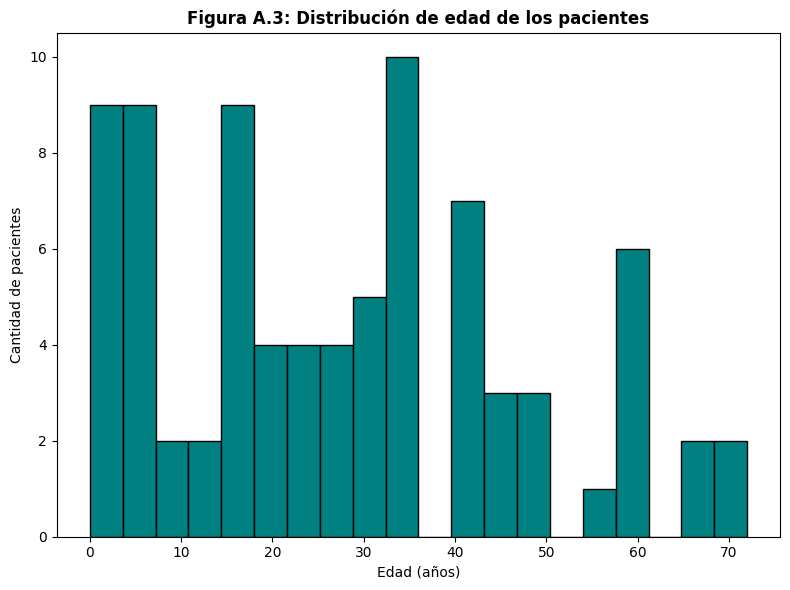

In [17]:
plt.figure(figsize=(8,6))
patient_demographics_df["Age_(years)"].plot.hist(bins=20, color="teal", edgecolor="black")
plt.title("Figura A.3: Distribución de edad de los pacientes", fontweight="bold")
plt.xlabel("Edad (años)")
plt.ylabel("Cantidad de pacientes")
plt.tight_layout()
plt.show()


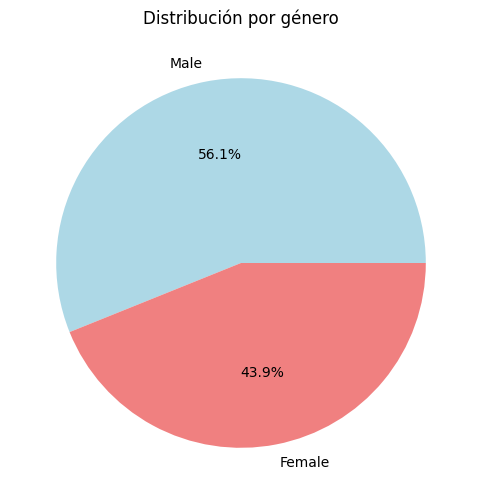

In [18]:
plt.figure(figsize=(8,6))
patient_demographics_df["Gender"].value_counts().plot.pie(
    autopct="%1.1f%%",
    labels=["Male", "Female"],
    colors=["lightblue", "lightcoral"]
)
plt.title("Distribución por género")
plt.ylabel("")
plt.show()


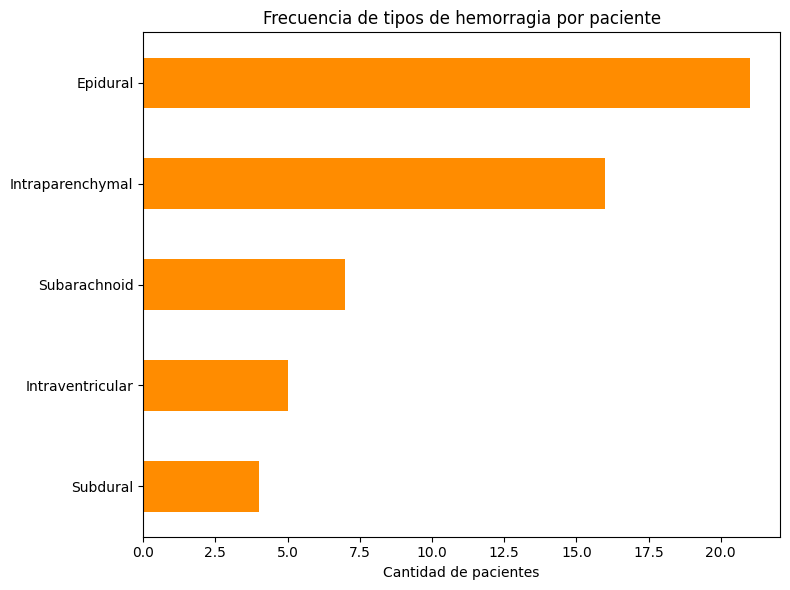

In [19]:
hem_types = ["Intraventricular", "Intraparenchymal", "Subarachnoid", "Epidural", "Subdural"]

plt.figure(figsize=(8,6))
patient_demographics_df[hem_types].sum().sort_values().plot.barh(color="darkorange")
plt.title("Frecuencia de tipos de hemorragia por paciente")
plt.xlabel("Cantidad de pacientes")
plt.tight_layout()
plt.show()


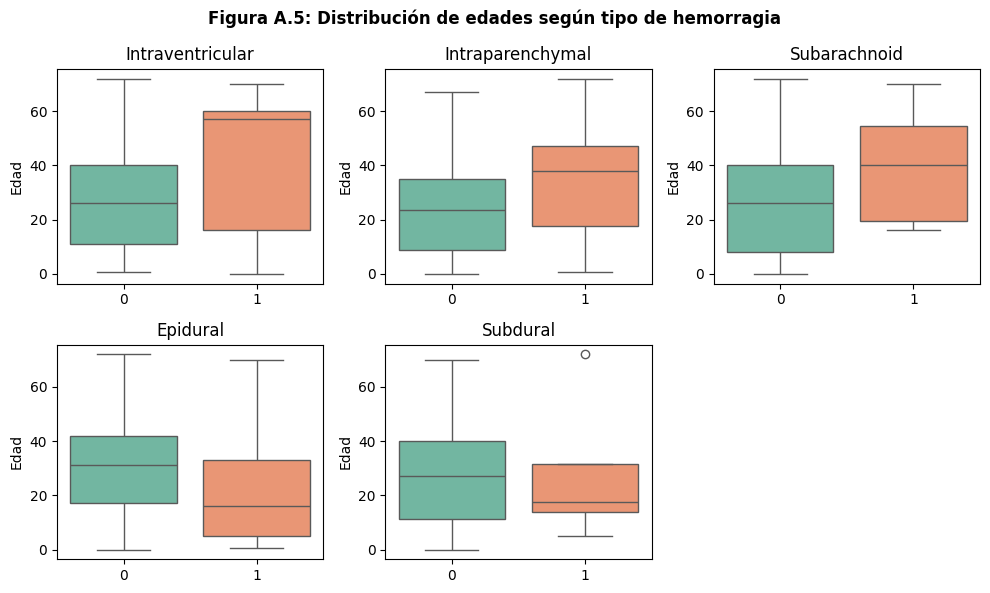

In [20]:
hem_types = ["Intraventricular", "Intraparenchymal", "Subarachnoid", "Epidural", "Subdural"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i, hem_type in enumerate(hem_types):
    sns.boxplot(
        x=patient_demographics_df[hem_type],
        y=patient_demographics_df["Age_(years)"],
        hue=patient_demographics_df[hem_type],
        ax=axes[i],
        palette="Set2",
        legend=False
    )
    axes[i].set_title(f"{hem_type}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Edad")

if len(hem_types) < len(axes):
    axes[-1].axis("off")

fig.suptitle("Figura A.5: Distribución de edades según tipo de hemorragia", fontweight="bold")
plt.tight_layout()
plt.show()


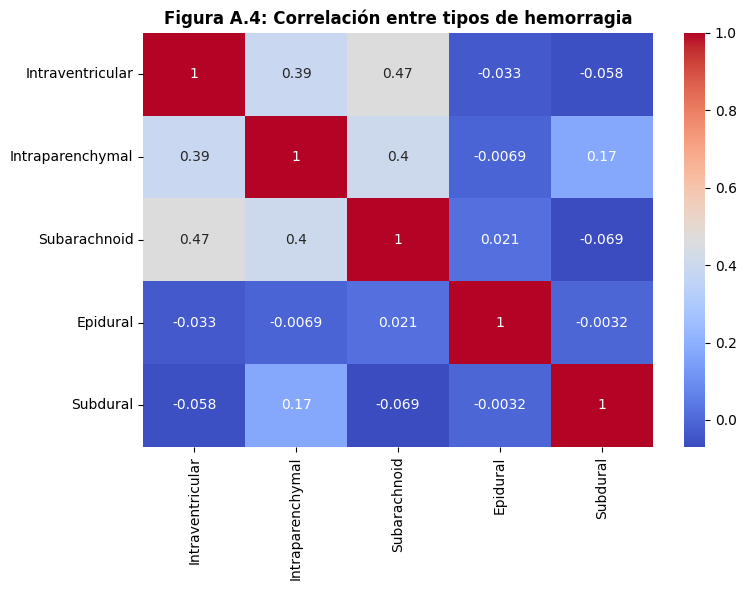

In [22]:
corr = patient_demographics_df[hem_types].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Figura A.4: Correlación entre tipos de hemorragia", fontweight="bold")
plt.tight_layout()
plt.show()


# Machine Learning
---
---

### Métrica objetvo -> recall y accuracy

### Juntar datos

In [22]:
temp_df = patient_demographics_df[['Patient_Number', 'Age_(years)', 'Gender', 'Condition_on_file']]

ml_merged_df = (
    hemorrhage_diagnosis_df.merge(
        temp_df, 
        left_on="Patient_Number", 
        right_on="Patient_Number", 
        how="left"
    )
)

ml_merged_df.head()

,Patient_Number,Slice_Number,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_(Yes/No),brain_path,has_brain_mask,bone_path,Age_(years),Gender,Condition_on_file
0,49,1,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,Male,Intracranial HGE+ Extradural HGE
1,49,2,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,Male,Intracranial HGE+ Extradural HGE
2,49,3,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,Male,Intracranial HGE+ Extradural HGE
3,49,4,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,Male,Intracranial HGE+ Extradural HGE
4,49,5,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,Male,Intracranial HGE+ Extradural HGE


### Variable objetivo: "Condition_on_file" (diagnóstico final)

In [23]:
ml_merged_df['Condition_on_file'].value_counts()

Condition_on_file
Normal CT                                              1431
Extradural HGE                                          400
Intracranial HGE                                        223
Subdural HGE                                             90
Intracranial HGE+ Extradural HGE                         66
Intracranial HGE + IVH                                   62
Extadural HGE                                            62
Chronic Intracranial HGE                                 34
Extradural HGE + Intracranial HGE + Extradural HGE       29
Subdural HGE+ Intracranial HGE                           29
ICH                                                      28
Intracranial HGE + Subdural HGE                          28
Subdural HGE +Intracranial HGE + IVH                     19
Name: count, dtype: int64

### Preprocessing

In [24]:
ml_merged_df['Condition_on_file'] = ml_merged_df['Condition_on_file'].str.strip()
ml_merged_df['Condition_on_file'] = ml_merged_df['Condition_on_file'].replace('Extadural HGE', 'Extradural HGE')
ml_merged_df["Gender"] = ml_merged_df["Gender"].map({"Male": 0, "Female": 1}).astype(int)

### Englobar las clases más raras (count < 70) en una nueva clasificación

In [25]:
counts = ml_merged_df['Condition_on_file'].value_counts()
rare_hge = counts[counts < 70].index.tolist()
ml_merged_df['Condition_on_file'] = ml_merged_df['Condition_on_file'].apply(lambda x: 'Rare HGE' if x in rare_hge else x)
print("Nueva distribución de clases:")
print(ml_merged_df['Condition_on_file'].value_counts())

Nueva distribución de clases:
Condition_on_file
Normal CT           1431
Extradural HGE       462
Rare HGE             295
Intracranial HGE     223
Subdural HGE          90
Name: count, dtype: int64


### Codificación

In [26]:
le = LabelEncoder()
ml_merged_df["Condition_encoded"] = le.fit_transform(ml_merged_df["Condition_on_file"])

In [27]:
ml_merged_df.head()

,Patient_Number,Slice_Number,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_(Yes/No),brain_path,has_brain_mask,bone_path,Age_(years),Gender,Condition_on_file,Condition_encoded
0,49,1,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,0,Rare HGE,3
1,49,2,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,0,Rare HGE,3
2,49,3,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,0,Rare HGE,3
3,49,4,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,0,Rare HGE,3
4,49,5,0,0,0,0,0,1,0,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...,35.0,0,Rare HGE,3


In [28]:
ml_merged_df.dtypes

Patient_Number         int64
Slice_Number           int64
Intraventricular       int64
Intraparenchymal       int64
Subarachnoid           int64
Epidural               int64
Subdural               int64
No_Hemorrhage          int64
Fracture_(Yes/No)      int64
brain_path            object
has_brain_mask        object
bone_path             object
Age_(years)          float64
Gender                 int64
Condition_on_file     object
Condition_encoded      int64
dtype: object

### Train-Test Split

In [29]:
X = ml_merged_df.drop(columns=[
    "Patient_Number", 
    "Condition_on_file", 
    "Condition_encoded", 
    "brain_path", 
    "bone_path", 
    "has_brain_mask"
])
y = ml_merged_df["Condition_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


### Modelos seleccionados: XGBoost, Random Forest y LightGBM

In [30]:
xgboost = 'xgb'
random_forest = 'rf'
lightgbm = 'lgbm'

### XGBoost

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mejores parámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


 99%|===================| 3099/3130 [00:46<00:00]        

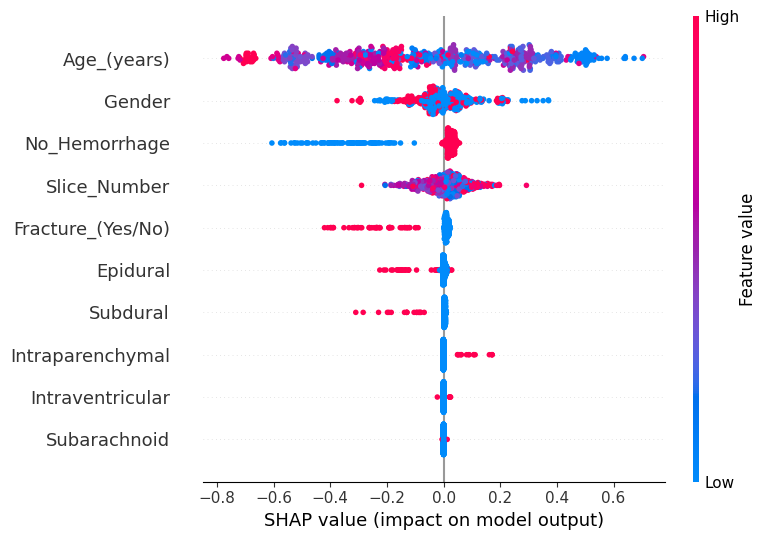

                  precision    recall  f1-score   support

  Extradural HGE       0.86      0.96      0.91       116
Intracranial HGE       0.65      0.91      0.76        56
       Normal CT       0.98      0.90      0.94       358
        Rare HGE       0.82      0.81      0.82        74
    Subdural HGE       0.84      0.73      0.78        22

        accuracy                           0.89       626
       macro avg       0.83      0.86      0.84       626
    weighted avg       0.91      0.89      0.90       626



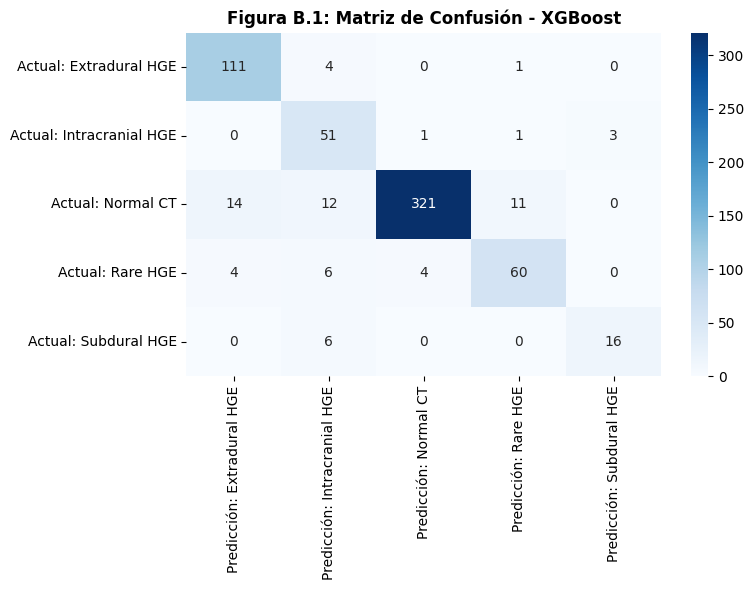

In [60]:
xgb_model, xgb_report, xgb_cm = ML_models.ML_report(
    X_train, X_test, 
    y_train, y_test, 
    le, model_name=xgboost
)
print(xgb_report)

plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Figura B.1: Matriz de Confusión - XGBoost", fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Random Forest

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


 98%|===================| 3077/3130 [00:17<00:00]        

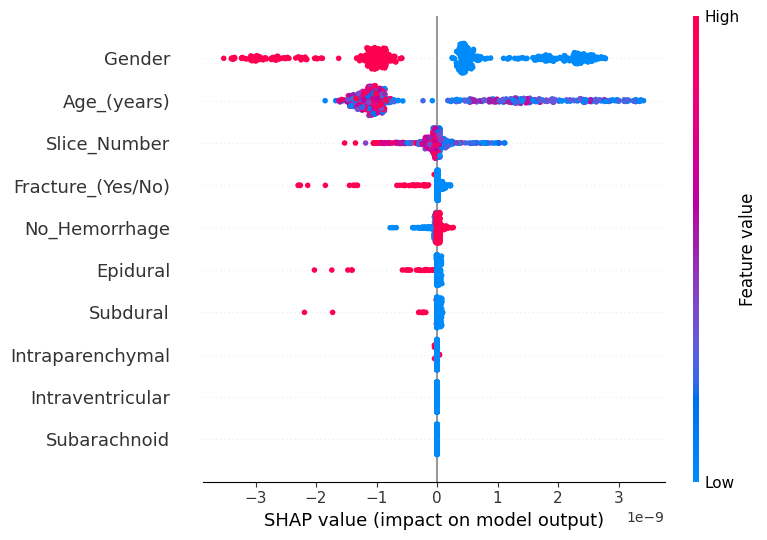

                  precision    recall  f1-score   support

  Extradural HGE       0.87      0.94      0.90       116
Intracranial HGE       0.66      0.79      0.72        56
       Normal CT       0.96      0.90      0.93       358
        Rare HGE       0.80      0.82      0.81        74
    Subdural HGE       0.85      0.77      0.81        22

        accuracy                           0.88       626
       macro avg       0.83      0.84      0.83       626
    weighted avg       0.89      0.88      0.89       626



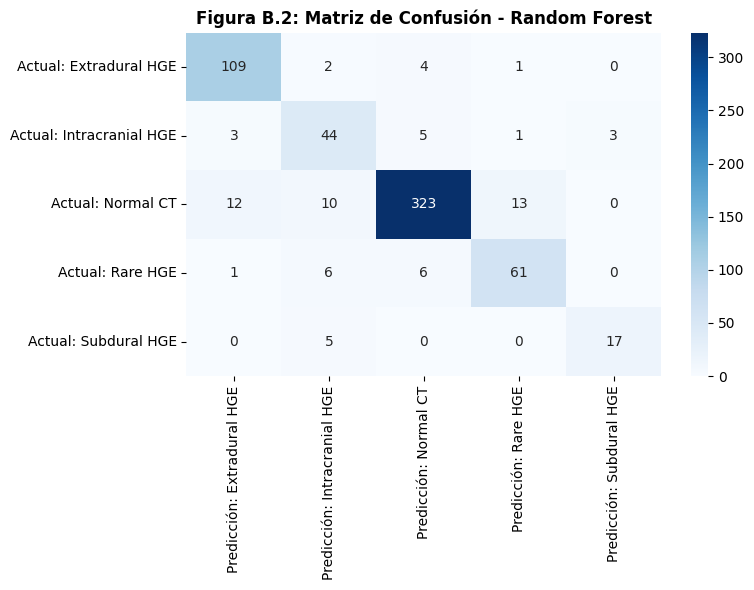

In [61]:
rf_model, rf_report, rf_cm = ML_models.ML_report(
    X_train, X_test, 
    y_train, y_test, 
    le, model_name=random_forest
)
print(rf_report)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Figura B.2: Matriz de Confusión - Random Forest", fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

### LightGBM

Mejores parámetros encontrados:
{'subsample': 0.9, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 255, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


 98%|===================| 3078/3130 [00:47<00:00]        

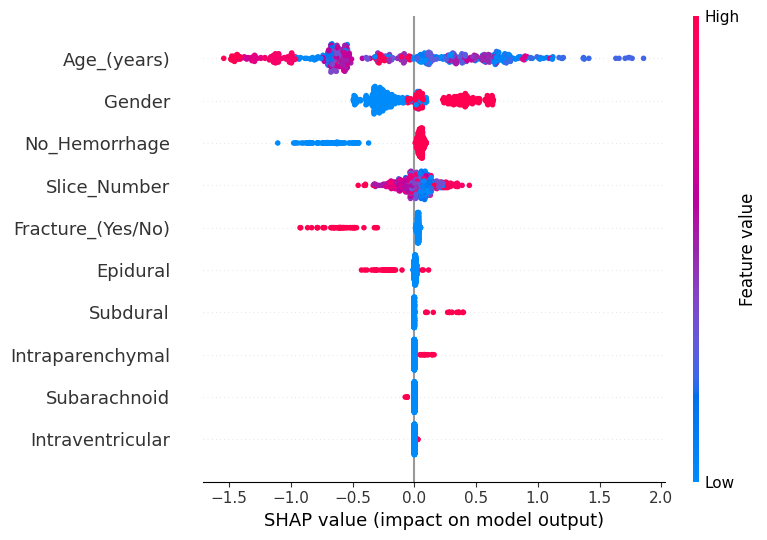

                  precision    recall  f1-score   support

  Extradural HGE       0.88      0.96      0.92       116
Intracranial HGE       0.65      0.93      0.76        56
       Normal CT       0.98      0.90      0.94       358
        Rare HGE       0.85      0.85      0.85        74
    Subdural HGE       0.84      0.73      0.78        22

        accuracy                           0.90       626
       macro avg       0.84      0.87      0.85       626
    weighted avg       0.91      0.90      0.90       626



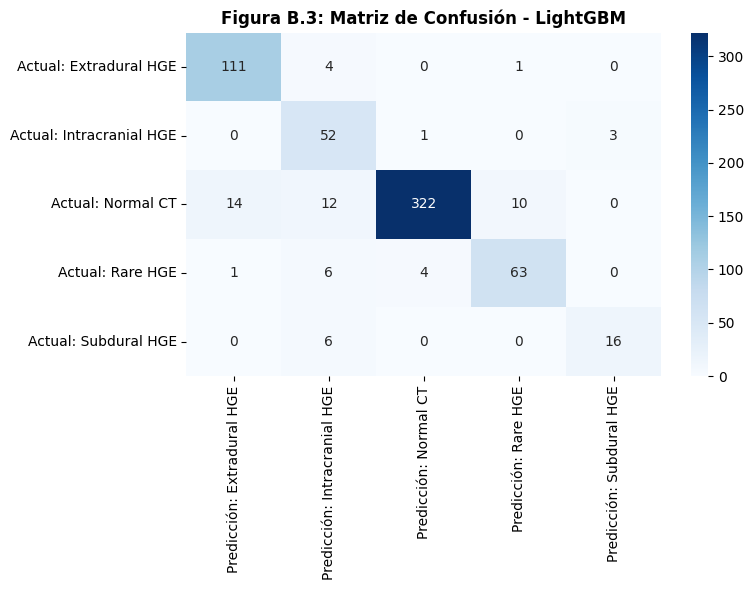

In [62]:
lgbm_model, lgbm_report, lgbm_cm, X_train_resampled, y_train_resampled = (
    ML_models.ML_report(
        X_train, X_test, 
        y_train, y_test, 
        le, model_name=lightgbm
    )
)
print(lgbm_report)

plt.figure(figsize=(8, 6))
sns.heatmap(lgbm_cm, annot=True, fmt='d', cmap="Blues")
plt.title("Figura B.3: Matriz de Confusión - LightGBM", fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Variables más influyentes (consistencia entre modelos)

En los tres modelos, las variables que aparecen como más influyentes son:

* Age_(years)

* Gender

* Slice_Number

* No_Hemorrhage

* Fracture_(Yes/No)

Esto sugiere que esas variables tienen un impacto real y consistente en las predicciones, independientemente del algoritmo.

### Modelo final: LightGBM (accuracy 0.90, recall [weighted avg] 0.90)

Su gráfico SHAP muestra que es más conservador en la importancia asignada a cada variable, haciéndolo menos propenso a sobreajuste.

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_model, X, y, cv=cv, scoring="accuracy")

print("Accuracy:", scores)
print("Media:", np.mean(scores), "±", np.std(scores))

Accuracy: [    0.88423       0.858       0.888       0.886       0.886]
Media: 0.8804463073852296 ± 0.011286363039941617


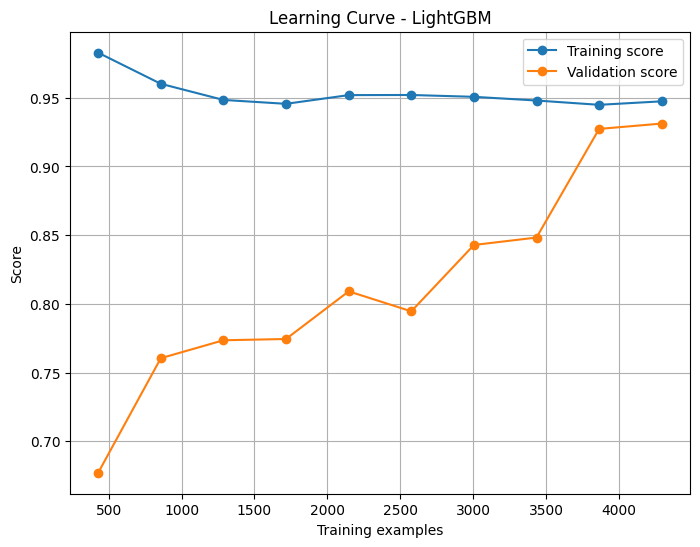

In [35]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=lgbm_model,
    X=X_train_resampled,
    y=y_train_resampled,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve - LightGBM')
plt.legend(loc='best')
plt.grid()
plt.show()


### La brecha entre entrenamiento y validación se reduce, lo que indica que el modelo está aprendiendo de forma más robusta.

# Segmentación de imágenes: YOLOv8
---
---

### Celda para eliminar directorio de datos de YOLO (descomentar)

In [ ]:
"""
path = 'data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg'
if os.path.exists(path):
    shutil.rmtree(path)
"""

### Preparación y separación de los directorios de datos para el modelo

In [3]:
manifest, stats = split_data.prepare_dataset(
    root='data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0', 
    patients_dir='Patients_CT', 
    hem_csv='hemorrhage_diagnosis.csv',
    out_dir='dataset_yolo_seg', 
    new_size=(512,512), 
    train_ratio=0.6,
    include_no_mask_as_negatives=True
)

base_dir = Path('data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg')
print('Processed:', stats)
display(manifest.head())

Processed: {'processed': 2501, 'with_mask': 318, 'no_mask': 2183, 'missing_image': 0}


,index,patient_id,slice,split,image_path,mask_exists,mask_path
0,0,106,1,train,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
1,1,106,2,train,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
2,2,106,3,train,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
3,3,106,4,train,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...
4,4,106,5,train,data/computed-tomography-images-for-intracrani...,False,data/computed-tomography-images-for-intracrani...


### Convertir las máscaras a coordenadas en formato de texto para la segmentación

In [4]:
split_data.convert_masks_to_yolo(base_dir)

### Balancear los datasets de entrenamiento y validación

In [5]:
balance_dataset.balance(
    base_dir,
    split='train',
    ratio=1
)

balance_dataset.balance(
    base_dir,
    split='val',
    ratio=1
)

train: 155 positivos, 1330 negativos
Guardado en data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images_train_balanced, data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels_train_balanced
val: 163 positivos, 853 negativos
Guardado en data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images_val_balanced, data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels_val_balanced


### Realizar submuestreo de las clases positivas y aumento de datos

In [6]:
balance_dataset.oversample_positives(
    base_dir,
    split='train',
    factor=5
)

balance_dataset.augment_positives(
    images_dir=f'{base_dir}/images/train_balanced',
    labels_dir=f'{base_dir}/labels/train_balanced',
    n_aug=10
)

✅ Augmentations agregadas en data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/train_balanced y data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels/train_balanced


### Reorganizar los directorios para YOLO

In [7]:
balance_dataset.reorganize_directories(dir=base_dir)

✅ Movidos 930 archivos de images_train_balanced a data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/train_balanced
✅ Movidos 930 archivos de labels_train_balanced a data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels/train_balanced
✅ Movidos 326 archivos de images_val_balanced a data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val_balanced
✅ Movidos 326 archivos de labels_val_balanced a data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels/val_balanced

Estructura reorganizada correctamente ✅


### Entrenamiento del modelo YOLOv8s-seg

In [ ]:
model = YOLO('yolo_models/yolov8s-seg.pt')

results = model.train(
    data='data_yaml_yolov8_seg.yaml',
    epochs=150,
    imgsz=640,
    batch=16,
    optimizer='AdamW',
    lr0=0.001,        
    patience=50,     
    device=0,         
    copy_paste=0.6,   
    mosaic=1.0,       
    mixup=0.0        
)

print(results)

New https://pypi.org/project/ultralytics/8.3.203 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.192 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.6, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_yaml_yolov8_seg.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train10, nbs=64, nms=False,

### Evaluar el modelo entrenado

In [2]:
model = YOLO('runs/segment/train_yolo_final/weights/best.pt') 
metrics = model.val(data='data_yaml_yolov8_seg.yaml', imgsz=640, batch=16)
print(metrics)

Ultralytics 8.3.192 🚀 Python-3.13.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 106.7±15.1 MB/s, size: 60.0 KB)
val: Scanning /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels/val_balanced.cache... 326 images, 163 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 326/326 586087.9it/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 3.4it/s 6.3s0.3s
                   all        326        418      0.483       0.17      0.246       0.12      0.457      0.177      0.239     0.0892
Speed: 0.8ms preprocess, 13.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/segment/val2
ultralytics.uti

### Predicción simple de máscara

In [ ]:
img_path = "data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/053_19.png"
res = model.predict(source=img_path, conf=0.05, imgsz=640, save=False) 

masks = res[0].masks 
if masks is not None and masks.data is not None:
    mask_array = masks.data.cpu().numpy()
    combined = (mask_array.sum(axis=0) > 0).astype(np.uint8) * 255
    out = Path("pred_mask.png")
    cv2.imwrite(str(out), combined)
    print("Saved:", out)
else:
    print("No masks predicted for", img_path)
    


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/053_19.png: 640x640 1 HGE, 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)
Saved: pred_mask.png


### Testeo completo del modelo segmentando 10 tomografías

image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/130_9.png: 640x640 (no detections), 17.6ms
Speed: 3.2ms preprocess, 17.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


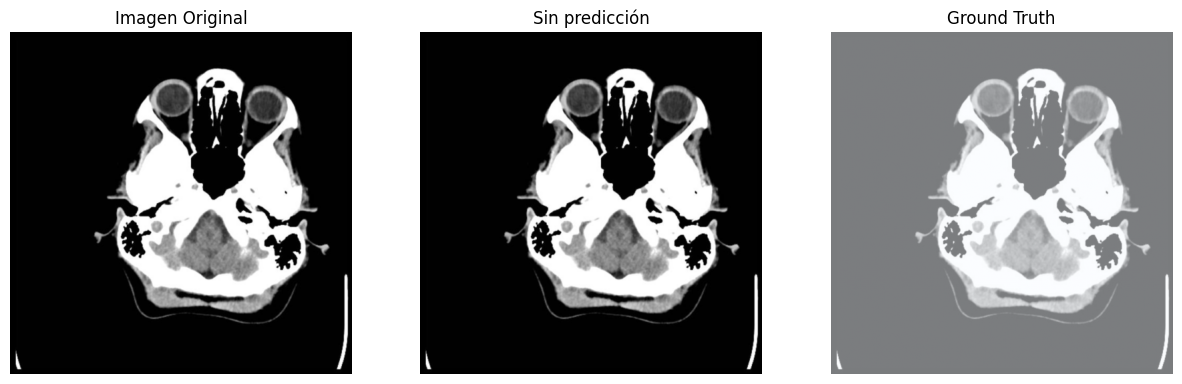


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/075_6.png: 640x640 (no detections), 17.5ms
Speed: 1.9ms preprocess, 17.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


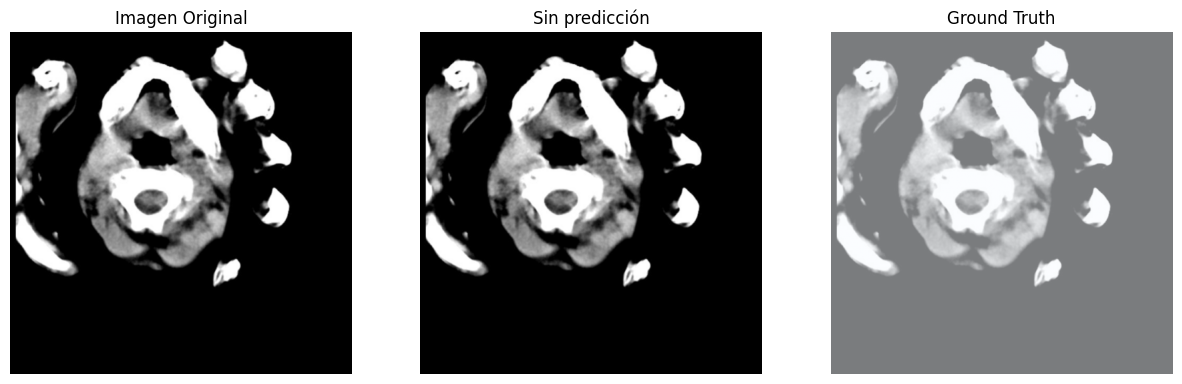


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/097_4.png: 640x640 (no detections), 19.6ms
Speed: 2.9ms preprocess, 19.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


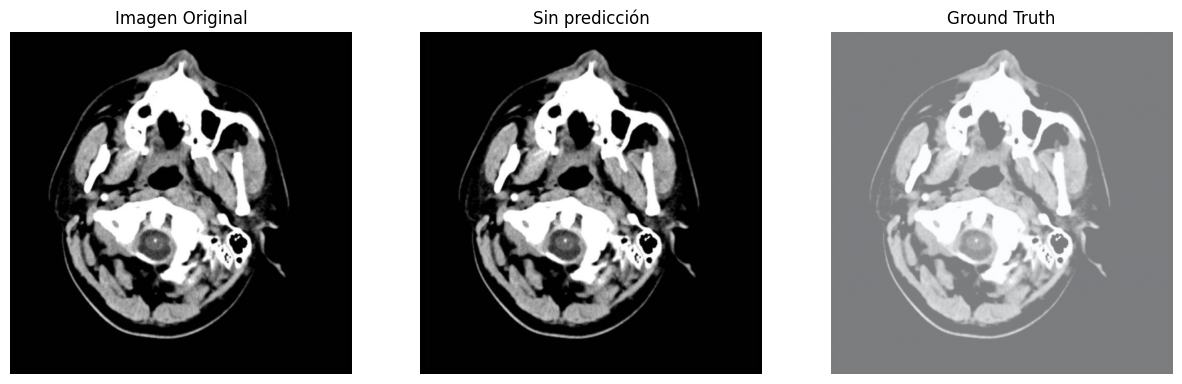


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/084_25.png: 640x640 1 HGE, 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


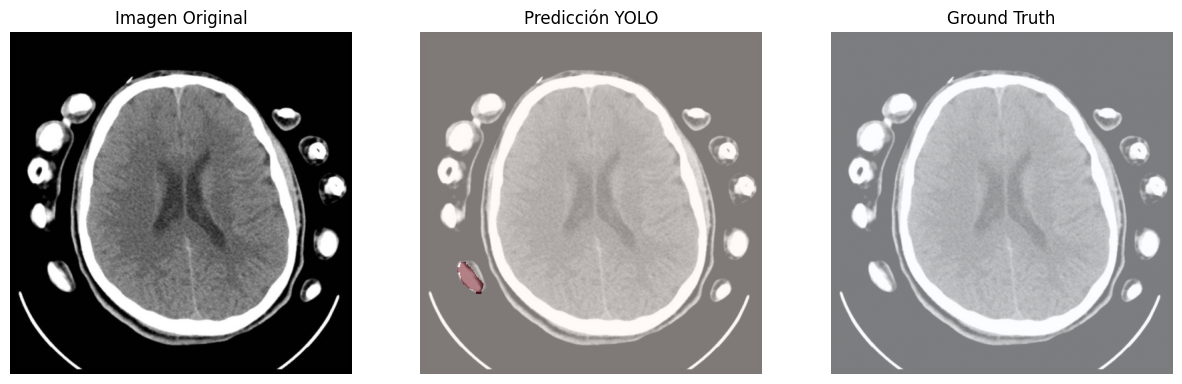


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/066_20.png: 640x640 1 HGE, 16.6ms
Speed: 1.8ms preprocess, 16.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


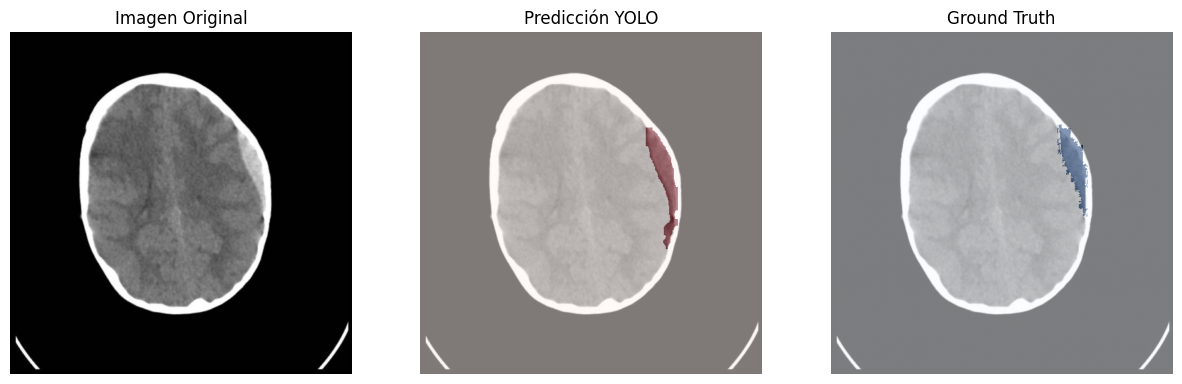


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/074_24.png: 640x640 1 HGE, 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


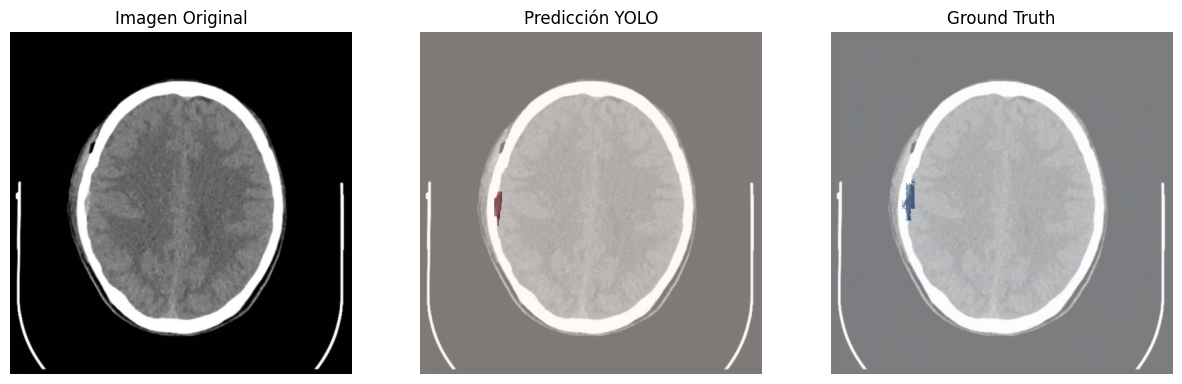


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/062_10.png: 640x640 (no detections), 26.9ms
Speed: 4.1ms preprocess, 26.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


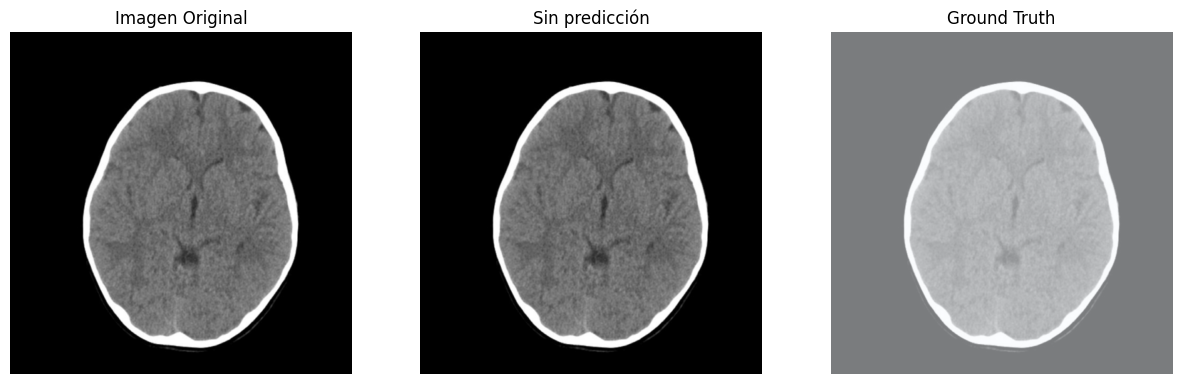


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/049_29.png: 640x640 (no detections), 24.9ms
Speed: 2.0ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


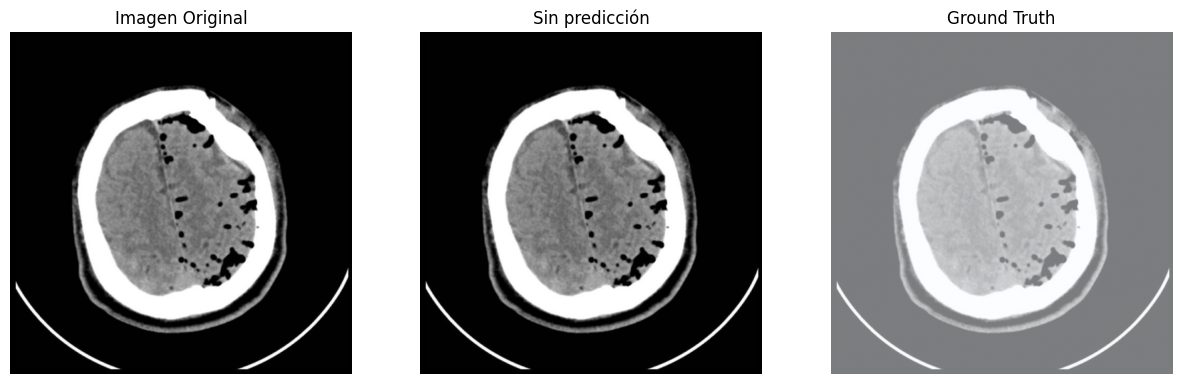


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/093_20.png: 640x640 (no detections), 28.9ms
Speed: 2.0ms preprocess, 28.9ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


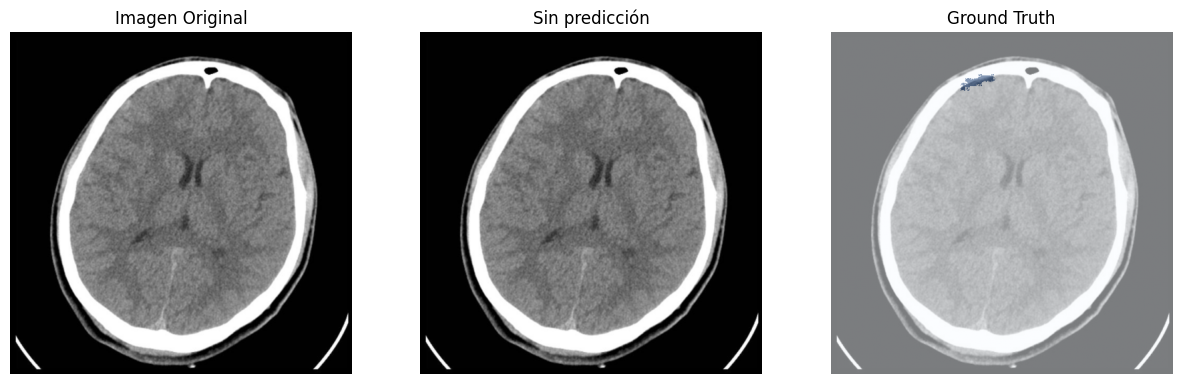


image 1/1 /home/nicolas/workspace/proyectos/final_v4/data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val/080_1.png: 640x640 (no detections), 29.2ms
Speed: 2.0ms preprocess, 29.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


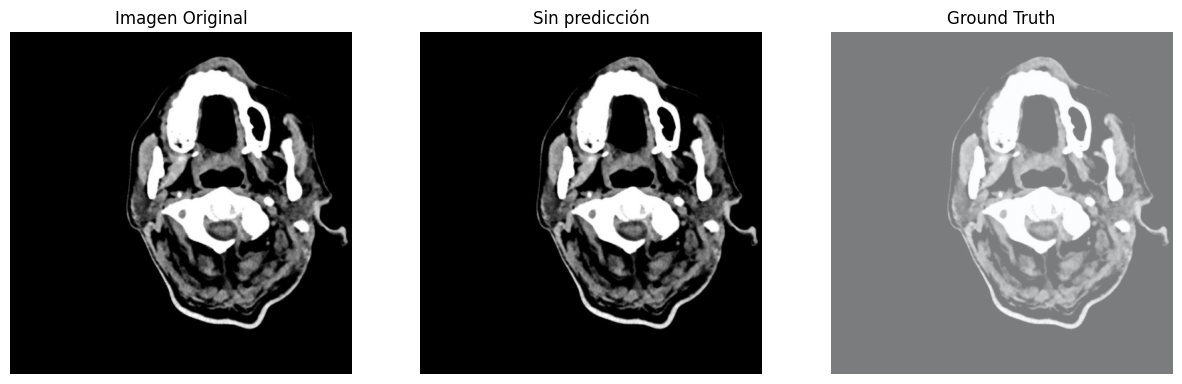

In [3]:
val_img_dir = Path("data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/images/val")
val_lbl_dir = Path("data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/dataset_yolo_seg/labels/val")

test_YOLO.test_images(
    model=model, 
    val_img_dir=val_img_dir, 
    val_lbl_dir=val_lbl_dir, 
    N=10
)

### Conclusión del modelo YOLO

El modelo parece predecir y segmentar correctamente cuando se trata de una hemorragia grande o muy obvia. Sin embargo, carece de la precisión necesaria para detectar los casos más imperceptibles (ya sea por ser muy pequeños o estar ocultos); esto se debe principalmente a la limitación en capacidad de procesamiento físico en el entorno donde se entrenó el modelo, lo que provocó que no sea posible utilizar una versión más potente del modelo, ni utilizar herramientas que exigen mucha memoria de video. También hay que tener en cuenta que el dataset está muy desbalanceado (solo un 12.7% de clases positivas), lo que dificulta más el entrenamiento.

Se logró una métrica mAP50 de 0.239, lo cual no cumple con el objetivo original de 0.5.

El modelo no está listo para su despliegue en su estado actual, pero puede ser usado como una muestra. Y en el caso de que se decida usarlo, se recomienda realizar un segundo análisis médico para confirmar.